### Convert and Yolact into ONNX and OpenVINO™

The yolact model is a simple, fully convolutional model for real-time instance segmentation

YOLACT is an acronym for "You Only Look At CoefficienTs," which reflects the core philosophy behind this state-of-the-art real-time instance segmentation model

Instance segmentation involves not only detecting objects in an image but also providing pixel-level segmentation masks for each individual object instance. This level of detail is crucial for various computer vision tasks such as object recognition, scene understanding, and robotic perception. However, instance segmentation is computationally intensive and typically requires complex algorithms that may not be suitable for real-time applications.


Key features and more details can be found in the original model [repository](https://github.com/dbolya/yolact).


This tutorial demonstrates step-by-step instructions on how to run YOLACT with OpenVINO. 

The tutorial consists of the following steps:
- Download the pretrained weights.
- Prepare the PyTorch model.
- Validate the original model.
- Convert the PyTorch model to ONNX.
- Convert the PyTorch model to Openvin IR.
- Validate the converted model.
- Run the model 

### Installation
Before loading the YOLACT model, ensure that you have the necessary dependencies installed. The notebooks' requierments.txt files covers pretty much all the dependencies, however it's missing only 2. Those are cython and pycocotools.  

In [42]:
# !pip install cython
# !pip install pycocotools
# !pip install gdown


### Imports and settings for various libraries and modules. 
The `utils` directory contains various utility functions and configurations for the model. It provides functionalities related to image processing, model post-processing, configuration management, and integration with external tools.


- `cfg, set_cfg, mask_type` are configuration files  related functions to use the pretrained model config.
- the `SavePath` class is used for reading/writing models' files or paths.
- `InterpolateModule` module, which handles image interpolation or resizing operations.
- `gdown` is a library for downloading files from the internet, suggesting the usage of file downloading functionality.
- ` resnetBottleneck`  the ResNet model architecture.
- `Detect` is a module related to object detection functionality.
- `postprocess` and `output_utils` are output-related utility functions, such as post-processing and image transformation operations.
- `import MEANS, COLORS, STD` are additional configuration values, such as mean values, colors, and standard deviations.

In [43]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import cv2
from utils.config import cfg, set_cfg, mask_type
from utils.postprocess.functions import SavePath
from utils.interpolate import InterpolateModule
import gdown
from os import path, makedirs
from typing import List
from torchvision.models.resnet import Bottleneck as resnetBottleneck
from itertools import product
from utils.postprocess import timer
from utils.detection import Detect
from utils.postprocess.output_utils import postprocess
from utils.postprocess.output_utils import undo_image_transformation
from utils.config import MEANS, COLORS, STD
from torch.onnx import export
from openvino.tools.mo import convert_model
from openvino.runtime import Core

ie = Core()

##### Downloading the Pretrained Weights
The YOLACT model comes with pretrained weights, which are trained on large-scale datasets such as COCO. You need to download the pretrained weights file before loading the model. You can obtain the weights from the official YOLACT repository or other reliable sources.

In [44]:
WEIGHTS_PATH = "weights"
if not path.exists(f"{WEIGHTS_PATH}"):
    makedirs(WEIGHTS_PATH)
# org model drive
# https://drive.google.com/file/d/1UYy3dMapbH1BnmtZU4WH1zbYgOzzHHf_/view
# my drive
# https://drive.google.com/file/d/1qW5tkaXySck51uPdmz-eoHKGTFha1IrC/view
MODEL_DRIVE_ID = "1qW5tkaXySck51uPdmz-eoHKGTFha1IrC"
MODEL_NAME = "yolact_base_54_800000"
output_path = f"{WEIGHTS_PATH}/{MODEL_NAME}.pth"
# gdown.download(id=MODEL_DRIVE_ID, output=output_path, fuzzy=True)

In [45]:
def construct_backbone(cfg):
    """ Constructs a backbone given a backbone config object (see config.py). """
    backbone = cfg.type(*cfg.args)

    # Add downsampling layers until we reach the number we need
    num_layers = max(cfg.selected_layers) + 1

    while len(backbone.layers) < num_layers:
        backbone.add_layer()

    return backbone


In [46]:
class Concat(nn.Module):
    """The Concat class is a PyTorch module that concatenates
    the output of multiple neural networks along the channel dimension."""

    def __init__(self, nets, extra_params):
        super().__init__()

        self.nets = nn.ModuleList(nets)
        self.extra_params = extra_params
    
    def forward(self, x):
        # Concat each along the channel dimension
        return torch.cat([net(x) for net in self.nets], dim=1, **self.extra_params)


def make_net(in_channels, conf, include_last_relu=True):
    """
    A helper function to take a config setting and turn it into a network.
    Used by protonet and extrahead. Returns (network, out_channels)
    """
    def make_layer(layer_cfg):
        nonlocal in_channels
        
        # Possible patterns:
        # ( 256, 3, {}) -> conv
        # ( 256,-2, {}) -> deconv
        # (None,-2, {}) -> bilinear interpolate
        # ('cat',[],{}) -> concat the subnetworks in the list
        #
        # You know it would have probably been simpler just to adopt a 'c' 'd' 'u' naming scheme.
        # Whatever, it's too late now.
        if isinstance(layer_cfg[0], str):
            layer_name = layer_cfg[0]

            if layer_name == 'cat':
                nets = [make_net(in_channels, x) for x in layer_cfg[1]]
                layer = Concat([net[0] for net in nets], layer_cfg[2])
                num_channels = sum([net[1] for net in nets])
        else:
            num_channels = layer_cfg[0]
            kernel_size = layer_cfg[1]

            if kernel_size > 0:
                layer = nn.Conv2d(in_channels, num_channels, kernel_size, **layer_cfg[2])
            else:
                if num_channels is None:
                    layer = InterpolateModule(scale_factor=-kernel_size, mode='bilinear', align_corners=False, **layer_cfg[2])
                else:
                    layer = nn.ConvTranspose2d(in_channels, num_channels, -kernel_size, **layer_cfg[2])
        
        in_channels = num_channels if num_channels is not None else in_channels

        # Don't return a ReLU layer if we're doing an upsample. This probably doesn't affect anything
        # output-wise, but there's no need to go through a ReLU here.
        # Commented out for backwards compatibility with previous models
        # if num_channels is None:
        #     return [layer]
        # else:
        return [layer, nn.ReLU(inplace=True)]

    # Use sum to concat together all the component layer lists
    net = sum([make_layer(x) for x in conf], [])
    if not include_last_relu:
        net = net[:-1]

    return nn.Sequential(*(net)), in_channels

In [47]:
ScriptModuleWrapper = nn.Module
def script_method_wrapper(fn, _rcn=None):
    return fn


class FPN(ScriptModuleWrapper):
    """
    Implements a general version of the FPN introduced in
    https://arxiv.org/pdf/1612.03144.pdf

    Parameters (in cfg.fpn):
        - num_features (int): The number of output features in the fpn layers.
        - interpolation_mode (str): The mode to pass to F.interpolate.
        - num_downsample (int): The number of downsampled layers to add onto the selected layers.
                                These extra layers are downsampled from the last selected layer.

    Args:
        - in_channels (list): For each conv layer you supply in the forward pass,
                              how many features will it have?
    """
    __constants__ = ['interpolation_mode', 'num_downsample', 'use_conv_downsample',
                     'lat_layers', 'pred_layers', 'downsample_layers']

    def __init__(self, in_channels):
        super().__init__()

        self.lat_layers  = nn.ModuleList([
            nn.Conv2d(x, cfg.fpn.num_features, kernel_size=1)
            for x in reversed(in_channels)
        ])

        # This is here for backwards compatability
        padding = 1 if cfg.fpn.pad else 0
        self.pred_layers = nn.ModuleList([
            nn.Conv2d(cfg.fpn.num_features, cfg.fpn.num_features, kernel_size=3, padding=padding)
            for _ in in_channels
        ])

        if cfg.fpn.use_conv_downsample:
            self.downsample_layers = nn.ModuleList([
                nn.Conv2d(cfg.fpn.num_features, cfg.fpn.num_features, kernel_size=3, padding=1, stride=2)
                for _ in range(cfg.fpn.num_downsample)
            ])
        
        self.interpolation_mode  = cfg.fpn.interpolation_mode
        self.num_downsample      = cfg.fpn.num_downsample
        self.use_conv_downsample = cfg.fpn.use_conv_downsample

    @script_method_wrapper
    def forward(self, convouts:List[torch.Tensor]):
        """
        Args:
            - convouts (list): A list of convouts for the corresponding layers in in_channels.
        Returns:
            - A list of FPN convouts in the same order as x with extra downsample layers if requested.
        """

        out = []
        x = torch.zeros(1, device=convouts[0].device)
        for i in range(len(convouts)):
            out.append(x)

        # For backward compatability, the conv layers are stored in reverse but the input and output is
        # given in the correct order. Thus, use j=-i-1 for the input and output and i for the conv layers.
        j = len(convouts)
        sizes = [(69, 69), (35, 35)]
        for lat_layer in self.lat_layers:
            j -= 1

            if j < len(convouts) - 1:
                #_, _, h, w = convouts[j].size()
                #x = F.interpolate(x, size=(h, w), mode=self.interpolation_mode, align_corners=False)
                x = F.interpolate(x, size=sizes[j], mode=self.interpolation_mode, align_corners=False)
            
            x = x + lat_layer(convouts[j])
            out[j] = x
        
        # This janky second loop is here because TorchScript.
        j = len(convouts)
        for pred_layer in self.pred_layers:
            j -= 1
            out[j] = F.relu(pred_layer(out[j]))

        # In the original paper, this takes care of P6
        if self.use_conv_downsample:
            for downsample_layer in self.downsample_layers:
                out.append(downsample_layer(out[-1]))
        else:
            for idx in range(self.num_downsample):
                # Note: this is an untested alternative to out.append(out[-1][:, :, ::2, ::2]). Thanks TorchScript.
                out.append(nn.functional.max_pool2d(out[-1], 1, stride=2))

        return out


In [48]:


class PredictionModule(nn.Module):
    """
    The (c) prediction module adapted from DSSD:
    https://arxiv.org/pdf/1701.06659.pdf

    Note that this is slightly different to the module in the paper
    because the Bottleneck block actually has a 3x3 convolution in
    the middle instead of a 1x1 convolution. Though, I really can't
    be arsed to implement it myself, and, who knows, this might be
    better.

    Args:
        - in_channels:   The input feature size.
        - out_channels:  The output feature size (must be a multiple of 4).
        - aspect_ratios: A list of lists of priorbox aspect ratios (one list per scale).
        - scales:        A list of priorbox scales relative to this layer's convsize.
                         For instance: If this layer has convouts of size 30x30 for
                                       an image of size 600x600, the 'default' (scale
                                       of 1) for this layer would produce bounding
                                       boxes with an area of 20x20px. If the scale is
                                       .5 on the other hand, this layer would consider
                                       bounding boxes with area 10x10px, etc.
        - parent:        If parent is a PredictionModule, this module will use all the layers
                         from parent instead of from this module.
    """
    
    def __init__(self, in_channels, out_channels=1024, aspect_ratios=[[1]], scales=[1], parent=None):
        super().__init__()

        self.num_classes = cfg.num_classes
        self.mask_dim    = cfg.mask_dim
        self.num_priors  = sum(len(x) for x in aspect_ratios)
        self.parent      = [parent] # Don't include this in the state dict

        if cfg.mask_proto_prototypes_as_features:
            in_channels += self.mask_dim
        
        if parent is None:
            if cfg.extra_head_net is None:
                out_channels = in_channels
            else:
                self.upfeature, out_channels = make_net(in_channels, cfg.extra_head_net)

            if cfg.use_prediction_module:
                self.block = resnetBottleneck(out_channels, out_channels // 4)
                self.conv = nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=True)
                self.bn = nn.BatchNorm2d(out_channels)

            self.bbox_layer = nn.Conv2d(out_channels, self.num_priors * 4,                **cfg.head_layer_params)
            self.conf_layer = nn.Conv2d(out_channels, self.num_priors * self.num_classes, **cfg.head_layer_params)
            self.mask_layer = nn.Conv2d(out_channels, self.num_priors * self.mask_dim,    **cfg.head_layer_params)

            if cfg.use_instance_coeff:
                self.inst_layer = nn.Conv2d(out_channels, self.num_priors * cfg.num_instance_coeffs, **cfg.head_layer_params)
            
            # What is this ugly lambda doing in the middle of all this clean prediction module code?
            def make_extra(num_layers):
                if num_layers == 0:
                    return lambda x: x
                else:
                    # Looks more complicated than it is. This just creates an array of num_layers alternating conv-relu
                    return nn.Sequential(*sum([[
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                        nn.ReLU(inplace=True)
                    ] for _ in range(num_layers)], []))

            self.bbox_extra, self.conf_extra, self.mask_extra = [make_extra(x) for x in cfg.extra_layers]
            
            if cfg.mask_type == mask_type.lincomb and cfg.mask_proto_coeff_gate:
                self.gate_layer = nn.Conv2d(out_channels, self.num_priors * self.mask_dim, kernel_size=3, padding=1)

        self.aspect_ratios = aspect_ratios
        self.scales = scales

        self.priors = None
        self.last_conv_size = None

    def forward(self, x):
        """
        Args:
            - x: The convOut from a layer in the backbone network
                 Size: [batch_size, in_channels, conv_h, conv_w])

        Returns a tuple (bbox_coords, class_confs, mask_output, prior_boxes) with sizes
            - bbox_coords: [batch_size, conv_h*conv_w*num_priors, 4]
            - class_confs: [batch_size, conv_h*conv_w*num_priors, num_classes]
            - mask_output: [batch_size, conv_h*conv_w*num_priors, mask_dim]
            - prior_boxes: [conv_h*conv_w*num_priors, 4]
        """
        # In case we want to use another module's layers
        src = self if self.parent[0] is None else self.parent[0]
        
        conv_h = x.size(2)
        conv_w = x.size(3)
        
        if cfg.extra_head_net is not None:
            x = src.upfeature(x)
        
        if cfg.use_prediction_module:
            # The two branches of PM design (c)
            a = src.block(x)
            
            b = src.conv(x)
            b = src.bn(b)
            b = F.relu(b)
            
            # TODO: Possibly switch this out for a product
            x = a + b

        bbox_x = src.bbox_extra(x)
        conf_x = src.conf_extra(x)
        mask_x = src.mask_extra(x)

        bbox = src.bbox_layer(bbox_x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, 4)
        conf = src.conf_layer(conf_x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.num_classes)
        if cfg.eval_mask_branch:
            mask = src.mask_layer(mask_x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.mask_dim)
        else:
            mask = torch.zeros(x.size(0), bbox.size(1), self.mask_dim, device=bbox.device)

        if cfg.use_instance_coeff:
            inst = src.inst_layer(x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, cfg.num_instance_coeffs)

        # See box_utils.decode for an explanation of this
        if cfg.use_yolo_regressors:
            bbox[:, :, :2] = torch.sigmoid(bbox[:, :, :2]) - 0.5
            bbox[:, :, 0] /= conv_w
            bbox[:, :, 1] /= conv_h

        if cfg.eval_mask_branch:
            if cfg.mask_type == mask_type.direct:
                mask = torch.sigmoid(mask)
            elif cfg.mask_type == mask_type.lincomb:
                mask = cfg.mask_proto_coeff_activation(mask)

                if cfg.mask_proto_coeff_gate:
                    gate = src.gate_layer(x).permute(0, 2, 3, 1).contiguous().view(x.size(0), -1, self.mask_dim)
                    mask = mask * torch.sigmoid(gate)
        
        priors = self.make_priors(conv_h, conv_w)

        preds = { 'loc': bbox, 'conf': conf, 'mask': mask, 'priors': priors }

        if cfg.use_instance_coeff:
            preds['inst'] = inst
        
        return preds
    
    def make_priors(self, conv_h, conv_w):
        """ Note that priors are [x,y,width,height] where (x,y) is the center of the box. """
        
        with timer.env('makepriors'):
            if self.last_conv_size != (conv_w, conv_h):
                prior_data = []

                # Iteration order is important (it has to sync up with the convout)
                for j, i in product(range(conv_h), range(conv_w)):
                    # +0.5 because priors are in center-size notation
                    x = (i + 0.5) / conv_w
                    y = (j + 0.5) / conv_h
                    
                    for scale, ars in zip(self.scales, self.aspect_ratios):
                        for ar in ars:
                            if not cfg.backbone.preapply_sqrt:
                                ar = np.sqrt(ar)

                            if cfg.backbone.use_pixel_scales:
                                w = scale * ar / cfg.max_size
                                # TODO: Fix this line.
                                h = scale * ar / cfg.max_size
                            else:
                                w = scale * ar / conv_w
                                h = scale / ar / conv_h

                            prior_data += [x, y, w, h]
                
                self.priors = torch.Tensor(prior_data).view(-1, 4)
                self.last_conv_size = (conv_w, conv_h)
        
        return self.priors

In [49]:
class Yolact(nn.Module):
    """


    ██╗   ██╗ ██████╗ ██╗      █████╗  ██████╗████████╗
    ╚██╗ ██╔╝██╔═══██╗██║     ██╔══██╗██╔════╝╚══██╔══╝
     ╚████╔╝ ██║   ██║██║     ███████║██║        ██║   
      ╚██╔╝  ██║   ██║██║     ██╔══██║██║        ██║   
       ██║   ╚██████╔╝███████╗██║  ██║╚██████╗   ██║   
       ╚═╝    ╚═════╝ ╚══════╝╚═╝  ╚═╝ ╚═════╝   ╚═╝ 


    You can set the arguments by chainging them in the backbone config object in config.py.

    Parameters (in cfg.backbone):
        - selected_layers: The indices of the conv layers to use for prediction.
        - pred_scales:     A list with len(selected_layers) containing tuples of scales (see PredictionModule)
        - pred_aspect_ratios: A list of lists of aspect ratios with len(selected_layers) (see PredictionModule)
    """

    def __init__(self):
        super().__init__()

        self.backbone = construct_backbone(cfg.backbone)

        if cfg.freeze_bn:
            self.freeze_bn()

        # Compute mask_dim here and add it back to the config. Make sure Yolact's constructor is called early!
        if cfg.mask_type == mask_type.direct:
            cfg.mask_dim = cfg.mask_size**2
        elif cfg.mask_type == mask_type.lincomb:
            if cfg.mask_proto_use_grid:
                self.grid = torch.Tensor(np.load(cfg.mask_proto_grid_file))
                self.num_grids = self.grid.size(0)
            else:
                self.num_grids = 0

            self.proto_src = cfg.mask_proto_src
            
            if self.proto_src is None: in_channels = 3
            elif cfg.fpn is not None: in_channels = cfg.fpn.num_features
            else: in_channels = self.backbone.channels[self.proto_src]
            in_channels += self.num_grids

            # The include_last_relu=false here is because we might want to change it to another function
            self.proto_net, cfg.mask_dim = make_net(in_channels, cfg.mask_proto_net, include_last_relu=False)

            if cfg.mask_proto_bias:
                cfg.mask_dim += 1


        self.selected_layers = cfg.backbone.selected_layers
        src_channels = self.backbone.channels

        if cfg.fpn is not None:
            # Some hacky rewiring to accomodate the FPN
            self.fpn = FPN([src_channels[i] for i in self.selected_layers])
            self.selected_layers = list(range(len(self.selected_layers) + cfg.fpn.num_downsample))
            src_channels = [cfg.fpn.num_features] * len(self.selected_layers)


        self.prediction_layers = nn.ModuleList()

        for idx, layer_idx in enumerate(self.selected_layers):
            # If we're sharing prediction module weights, have every module's parent be the first one
            parent = None
            if cfg.share_prediction_module and idx > 0:
                parent = self.prediction_layers[0]

            pred = PredictionModule(src_channels[layer_idx], src_channels[layer_idx],
                                    aspect_ratios = cfg.backbone.pred_aspect_ratios[idx],
                                    scales        = cfg.backbone.pred_scales[idx],
                                    parent        = parent)
            self.prediction_layers.append(pred)

        # Extra parameters for the extra losses
        if cfg.use_class_existence_loss:
            # This comes from the smallest layer selected
            # Also note that cfg.num_classes includes background
            self.class_existence_fc = nn.Linear(src_channels[-1], cfg.num_classes - 1)
        
        if cfg.use_semantic_segmentation_loss:
            self.semantic_seg_conv = nn.Conv2d(src_channels[0], cfg.num_classes-1, kernel_size=1)

        # For use in evaluation
        self.detect = Detect(cfg.num_classes, bkg_label=0, top_k=200, conf_thresh=0.05, nms_thresh=0.5)

    def save_weights(self, path):
        """ Saves the model's weights using compression because the file sizes were getting too big. """
        torch.save(self.state_dict(), path)
    
    def load_weights(self, path):
        """ Loads weights from a compressed save file. """
        state_dict = torch.load(path, map_location='cpu')

        # For backward compatability, remove these (the new variable is called layers)
        for key in list(state_dict.keys()):
            if key.startswith('backbone.layer') and not key.startswith('backbone.layers'):
                del state_dict[key]
        
            # Also for backward compatibility with v1.0 weights, do this check
            if key.startswith('fpn.downsample_layers.'):
                if cfg.fpn is not None and int(key.split('.')[2]) >= cfg.fpn.num_downsample:
                    del state_dict[key]

        self.load_state_dict(state_dict)

    def init_weights(self, backbone_path):
        """ Initialize weights for training. """
        # Initialize the backbone with the pretrained weights.
        self.backbone.init_backbone(backbone_path)

        # Initialize the rest of the conv layers with xavier
        for name, module in self.named_modules():
            if isinstance(module, nn.Conv2d) and module not in self.backbone.backbone_modules:
                nn.init.xavier_uniform_(module.weight.data)
                
                if module.bias is not None:
                    if cfg.use_focal_loss and 'conf_layer' in name:
                        if not cfg.use_sigmoid_focal_loss:
                            # Initialize the last layer as in the focal loss paper.
                            # Because we use softmax and not sigmoid, I had to derive an alternate expression
                            # on a notecard. Define pi to be the probability of outputting a foreground detection.
                            # Then let z = sum(exp(x)) - exp(x_0). Finally let c be the number of foreground classes.
                            # Chugging through the math, this gives us
                            #   x_0 = log(z * (1 - pi) / pi)    where 0 is the background class
                            #   x_i = log(z / c)                for all i > 0
                            # For simplicity (and because we have a degree of freedom here), set z = 1. Then we have
                            #   x_0 =  log((1 - pi) / pi)       note: don't split up the log for numerical stability
                            #   x_i = -log(c)                   for all i > 0
                            module.bias.data[0]  = np.log((1 - cfg.focal_loss_init_pi) / cfg.focal_loss_init_pi)
                            module.bias.data[1:] = -np.log(module.bias.size(0) - 1)
                        else:
                            module.bias.data[0]  = -np.log(cfg.focal_loss_init_pi / (1 - cfg.focal_loss_init_pi))
                            module.bias.data[1:] = -np.log((1 - cfg.focal_loss_init_pi) / cfg.focal_loss_init_pi)
                    else:
                        module.bias.data.zero_()

    def train(self, mode=True):
        super().train(mode)

        if cfg.freeze_bn:
            self.freeze_bn()

    def freeze_bn(self):
        """ Adapted from https://discuss.pytorch.org/t/how-to-train-with-frozen-batchnorm/12106/8 """
        for module in self.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()

                module.weight.requires_grad = False
                module.bias.requires_grad = False

    def forward(self, x):
        """ The input should be of size [batch_size, 3, img_h, img_w] """
        with timer.env('backbone'):
            outs = self.backbone(x)

        if cfg.fpn is not None:
            with timer.env('fpn'):
                # Use backbone.selected_layers because we overwrote self.selected_layers
                outs = [outs[i] for i in cfg.backbone.selected_layers]
                outs = self.fpn(outs)

        proto_out = None
        if cfg.mask_type == mask_type.lincomb and cfg.eval_mask_branch:
            with timer.env('proto'):
                proto_x = x if self.proto_src is None else outs[self.proto_src]
                
                if self.num_grids > 0:
                    grids = self.grid.repeat(proto_x.size(0), 1, 1, 1)
                    proto_x = torch.cat([proto_x, grids], dim=1)

                proto_out = self.proto_net(proto_x)
                proto_out = cfg.mask_proto_prototype_activation(proto_out)

                if cfg.mask_proto_prototypes_as_features:
                    # Clone here because we don't want to permute this, though idk if contiguous makes this unnecessary
                    proto_downsampled = proto_out.clone()

                    if cfg.mask_proto_prototypes_as_features_no_grad:
                        proto_downsampled = proto_out.detach()
                
                # Move the features last so the multiplication is easy
                proto_out = proto_out.permute(0, 2, 3, 1).contiguous()

                if cfg.mask_proto_bias:
                    bias_shape = [x for x in proto_out.size()]
                    bias_shape[-1] = 1
                    proto_out = torch.cat([proto_out, torch.ones(*bias_shape)], -1)


        with timer.env('pred_heads'):
            pred_outs = { 'loc': [], 'conf': [], 'mask': [], 'priors': [] }

            if cfg.use_instance_coeff:
                pred_outs['inst'] = []
            
            for idx, pred_layer in zip(self.selected_layers, self.prediction_layers):
                pred_x = outs[idx]

                if cfg.mask_type == mask_type.lincomb and cfg.mask_proto_prototypes_as_features:
                    # Scale the prototypes down to the current prediction layer's size and add it as inputs
                    proto_downsampled = F.interpolate(proto_downsampled, size=outs[idx].size()[2:], mode='bilinear', align_corners=False)
                    pred_x = torch.cat([pred_x, proto_downsampled], dim=1)

                # A hack for the way dataparallel works
                if cfg.share_prediction_module and pred_layer is not self.prediction_layers[0]:
                    pred_layer.parent = [self.prediction_layers[0]]

                p = pred_layer(pred_x)
                
                for k, v in p.items():
                    pred_outs[k].append(v)

        for k, v in pred_outs.items():
            pred_outs[k] = torch.cat(v, -2)

        if proto_out is not None:
            pred_outs['proto'] = proto_out

        if self.training:

            # For the extra loss functions
            if cfg.use_class_existence_loss:
                pred_outs['classes'] = self.class_existence_fc(outs[-1].mean(dim=(2, 3)))

            if cfg.use_semantic_segmentation_loss:
                pred_outs['segm'] = self.semantic_seg_conv(outs[0])

            return pred_outs
        else:
            if cfg.use_sigmoid_focal_loss:
                # Note: even though conf[0] exists, this mode doesn't train it so don't use it
                pred_outs['conf'] = torch.sigmoid(pred_outs['conf'])
            elif cfg.use_objectness_score:
                # See focal_loss_sigmoid in multibox_loss.py for details
                objectness = torch.sigmoid(pred_outs['conf'][:, :, 0])
                pred_outs['conf'][:, :, 1:] = objectness[:, :, None] * F.softmax(pred_outs['conf'][:, :, 1:], -1)
                pred_outs['conf'][:, :, 0 ] = 1 - objectness
            else:
                pred_outs['conf'] = F.softmax(pred_outs['conf'], -1)

            #return self.detect(pred_outs)
            return pred_outs['loc'], pred_outs['conf'], pred_outs['mask'], pred_outs['priors'], pred_outs['proto']




In [50]:
class YOLACTConfig:
    """
    The YOLACTConfig class is used to configure
    various settings and parameters for the YOLACT object detection model.
    The class encapsulates the configuration options for the model
    allowing users to easily customize the model's
    behavior and settings based on their specific needs.
    The original used a parser functionality to run the model from CLI
    , which is not suitable for a notebook.
    """

    def __init__(
        self,
        top_k=5,
        cuda=True,
        fast_nms=True,
        display_masks=True,
        display_bboxes=True,
        display_text=True,
        display_scores=True,
        display=False,
        shuffle=False,
        ap_data_file="results/ap_data.pkl",
        resume=False,
        max_images=-1,
        output_coco_json=False,
        bbox_det_file="results/bbox_detections.json",
        mask_det_file="results/mask_detections.json",
        config=None,
        output_web_json=False,
        web_det_path="web/dets/",
        no_bar=False,
        display_lincomb=False,
        benchmark=False,
        no_sort=False,
        seed=None,
        mask_proto_debug=False,
        crop=True,
        image=None,
        images=None,
        video=None,
        video_multiframe=1,
        score_threshold=0,
        dataset=None,
        detect=False,
    ):
        # self.trained_model = "weights/yolact_base_54_800000.pth"
        self.top_k = top_k
        self.cuda = cuda
        self.fast_nms = fast_nms
        self.display_masks = display_masks
        self.display_bboxes = display_bboxes
        self.display_text = display_text
        self.display_scores = display_scores
        self.display = display
        self.shuffle = shuffle
        self.ap_data_file = ap_data_file
        self.resume = resume
        self.max_images = max_images
        self.output_coco_json = output_coco_json
        self.bbox_det_file = bbox_det_file
        self.mask_det_file = mask_det_file
        self.config = config
        self.output_web_json = output_web_json
        self.web_det_path = web_det_path
        self.no_bar = no_bar
        self.display_lincomb = display_lincomb
        self.benchmark = benchmark
        self.no_sort = no_sort
        self.seed = seed
        self.mask_proto_debug = mask_proto_debug
        self.crop = crop
        self.image = image
        self.images = images
        self.video = video
        self.video_multiframe = video_multiframe
        self.score_threshold = score_threshold
        self.dataset = dataset
        self.detect = detect
        self.display_fps=False

### Initializing the model using the default config for the pretrained model
1. An instance of the YOLACT model is created.
2. An instance of the `YOLACTConfig` class is created with specific configuration options.
3. The path to the trained model file is set.
4. A `SavePath` object is created from the model file path.
5. The pretrained weights are loaded into the YOLACT model.
6. The YOLACT model is put in evaluation mode.


In [51]:
args = YOLACTConfig()
net = Yolact()
args.trained_model = "weights/" + MODEL_NAME + ".pth"
args.image = "../data/image/coco_bike.jpg"
model_path = SavePath.from_str(args.trained_model)
args.config = model_path.model_name + "_config"
args.mask_proto_debug=False
set_cfg(args.config)
net.detect.use_fast_nms = args.fast_nms

In [52]:
net.load_weights(args.trained_model)
net.eval()

In [53]:
def prep_display(net, dets_out, img, h, w, undo_transform=True, class_color=False, mask_alpha=0.45, fps_str=''):
    """
    Note: If undo_transform=False then im_h and im_w are allowed to be None.
    """
    if undo_transform:
        img_numpy = undo_image_transformation(img, w, h)
        img_gpu = torch.Tensor(img_numpy).cuda()
    else:
        img_gpu = img / 255.0
        h, w, _ = img.shape
    
    with timer.env('Postprocess'):
        save = cfg.rescore_bbox
        cfg.rescore_bbox = True
        
        preds = net.detect({'loc': dets_out[0], 'conf': dets_out[1], 'mask':dets_out[2], 'priors': dets_out[3], 'proto': dets_out[4]}, net)

        t = postprocess(preds, w, h, visualize_lincomb = args.display_lincomb,
                                        crop_masks        = args.crop,
                                        score_threshold   = args.score_threshold)
        cfg.rescore_bbox = save

    with timer.env('Copy'):
        idx = t[1].argsort(0, descending=True)[:args.top_k]
        
        if cfg.eval_mask_branch:
            # Masks are drawn on the GPU, so don't copy
            masks = t[3][idx]
        classes, scores, boxes = [x[idx].cpu().numpy() for x in t[:3]]

    num_dets_to_consider = min(args.top_k, classes.shape[0])
    for j in range(num_dets_to_consider):
        if scores[j] < args.score_threshold:
            num_dets_to_consider = j
            break

    # Quick and dirty lambda for selecting the color for a particular index
    # Also keeps track of a per-gpu color cache for maximum speed
    def get_color(j, on_gpu=None):
        global color_cache
        color_idx = (classes[j] * 5 if class_color else j * 5) % len(COLORS)
        
        if on_gpu is not None and color_idx in color_cache[on_gpu]:
            return color_cache[on_gpu][color_idx]
        else:
            color = COLORS[color_idx]
            if not undo_transform:
                # The image might come in as RGB or BRG, depending
                color = (color[2], color[1], color[0])
            if on_gpu is not None:
                color = torch.Tensor(color).to(on_gpu).float() / 255.
                color_cache[on_gpu][color_idx] = color
            return color

    # First, draw the masks on the GPU where we can do it really fast
    # Beware: very fast but possibly unintelligible mask-drawing code ahead
    # I wish I had access to OpenGL or Vulkan but alas, I guess Pytorch tensor operations will have to suffice
    if args.display_masks and cfg.eval_mask_branch and num_dets_to_consider > 0:
        # After this, mask is of size [num_dets, h, w, 1]
        masks = masks[:num_dets_to_consider, :, :, None]
        
        # Prepare the RGB images for each mask given their color (size [num_dets, h, w, 1])
        # colors = torch.cat([get_color(j, on_gpu=img_gpu.device.index).view(1, 1, 1, 3) for j in range(num_dets_to_consider)], dim=0)
        colors = torch.cat(
            [
                torch.FloatTensor(get_color(j, on_gpu=img.device.index)).view(
                    1, 1, 1, 3
                )
                for j in range(num_dets_to_consider)
            ],
            dim=0,
        )

        masks_color = masks.repeat(1, 1, 1, 3) * colors * mask_alpha

        # This is 1 everywhere except for 1-mask_alpha where the mask is
        inv_alph_masks = masks * (-mask_alpha) + 1
        
        # I did the math for this on pen and paper. This whole block should be equivalent to:
        #    for j in range(num_dets_to_consider):
        #        img_gpu = img_gpu * inv_alph_masks[j] + masks_color[j]
        masks_color_summand = masks_color[0]
        if num_dets_to_consider > 1:
            inv_alph_cumul = inv_alph_masks[:(num_dets_to_consider-1)].cumprod(dim=0)
            masks_color_cumul = masks_color[1:] * inv_alph_cumul
            masks_color_summand += masks_color_cumul.sum(dim=0)

        img_gpu = img_gpu * inv_alph_masks.prod(dim=0) + masks_color_summand
    
    if args.display_fps:
            # Draw the box for the fps on the GPU
        font_face = cv2.FONT_HERSHEY_DUPLEX
        font_scale = 0.6
        font_thickness = 1

        text_w, text_h = cv2.getTextSize(fps_str, font_face, font_scale, font_thickness)[0]

        img_gpu[0:text_h+8, 0:text_w+8] *= 0.6 # 1 - Box alpha


    # Then draw the stuff that needs to be done on the cpu
    # Note, make sure this is a uint8 tensor or opencv will not anti alias text for whatever reason
    img_numpy = (img_gpu * 255).byte().cpu().numpy()

    if args.display_fps:
        # Draw the text on the CPU
        text_pt = (4, text_h + 2)
        text_color = [255, 255, 255]

        cv2.putText(img_numpy, fps_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
    
    if num_dets_to_consider == 0:
        return img_numpy

    if args.display_text or args.display_bboxes:
        for j in reversed(range(num_dets_to_consider)):
            x1, y1, x2, y2 = boxes[j, :]
            color = get_color(j)
            score = scores[j]

            if args.display_bboxes:
                cv2.rectangle(img_numpy, (x1, y1), (x2, y2), color, 1)

            if args.display_text:
                _class = cfg.dataset.class_names[classes[j]]
                text_str = '%s: %.2f' % (_class, score) if args.display_scores else _class

                font_face = cv2.FONT_HERSHEY_DUPLEX
                font_scale = 0.6
                font_thickness = 1

                text_w, text_h = cv2.getTextSize(text_str, font_face, font_scale, font_thickness)[0]

                text_pt = (x1, y1 - 3)
                text_color = [255, 255, 255]

                cv2.rectangle(img_numpy, (x1, y1), (x1 + text_w, y1 - text_h - 4), color, -1)
                cv2.putText(img_numpy, text_str, text_pt, font_face, font_scale, text_color, font_thickness, cv2.LINE_AA)
            
    
    return img_numpy

In [54]:
class FastBaseTransform(torch.nn.Module):
    """
    Transform that does all operations on the GPU for super speed.
    This doesn't suppport a lot of config settings
    and should only be used for production.
    Maintain this as necessary.
    """

    def __init__(self):
        super().__init__()

        self.mean = torch.Tensor(MEANS).float().cuda()[None, :, None, None]
        self.std  = torch.Tensor( STD ).float().cuda()[None, :, None, None]
        # self.mean = torch.Tensor(MEANS).float()[None, :, None, None]
        # self.std = torch.Tensor(STD).float()[None, :, None, None]
        self.transform = cfg.backbone.transform

    def forward(self, img):
        self.mean = self.mean.to(img.device)
        self.std = self.std.to(img.device)

        # img assumed to be a pytorch BGR image with channel order [n, h, w, c]
        if cfg.preserve_aspect_ratio:
            raise NotImplementedError

        img = img.permute(0, 3, 1, 2).contiguous()
        img = F.interpolate(img, (cfg.max_size, cfg.max_size),
                            mode="bilinear", align_corners=False)

        if self.transform.normalize:
            img = (img - self.mean) / self.std
        elif self.transform.subtract_means:
            img = img - self.mean
        elif self.transform.to_float:
            img = img / 255

        if self.transform.channel_order != "RGB":
            raise NotImplementedError

        img = img[:, (2, 1, 0), :, :].contiguous()

        # Return value is in channel order [n, c, h, w] and RGB
        return img

### validating the original model

In [55]:
def evalimage(net, path):
    """
    Perform inference using the original model
    on an input image and display the results.
    Args:
        path (str): Path to the input image file.
    Returns:
        None
    """
    frame = torch.from_numpy(cv2.imread(path)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)
    # img_numpy = prep_display(preds, frame, None, None, undo_transform=False)
    img_numpy = prep_display(net, preds, frame, None, None, undo_transform=False)
    img_numpy = img_numpy[:, :, (2, 1, 0)]
    plt.imshow(img_numpy)
    plt.title(path)
    plt.show()


with torch.no_grad():
    evalimage(net, args.image)

TypeError: '>' not supported between instances of 'tuple' and 'int'

### Exporting the model into ONNX format 

In [ ]:
MODELS_PATH = "models"
if not path.exists(f"{MODELS_PATH}"):
    makedirs(MODELS_PATH)
onnx_model_path = f"{MODELS_PATH}/{MODEL_NAME}.onnx"


In [ ]:
if path.exists(f"{MODELS_PATH}"):
    net.eval()
    input_names = ["actual_input"]
    output_names = ["output"]
    frame = torch.from_numpy(cv2.imread(args.image)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    preds = net(batch)
    export(
        net,
        batch,
        onnx_model_path,
        input_names=input_names,
        output_names=output_names,
        export_params=True,
    )

C:\Users\Terep\AppData\Local\Temp\ipykernel_19200\3632478785.py:153: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.last_conv_size != (conv_w, conv_h):
c:\Users\Terep\Desktop\Learning\openvino_notebooks\notebooks\238-yolact-instance-segmentation\utils\detection.py:99: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if scores.size(1) == 0:
c:\Users\Terep\Desktop\Learning\ov_venv\lib\site-packages\torch\onnx\symbolic_opset9.py:5535: UserWarning: Exporting aten::index operator with indices of type Byte. Only 1-D indices are supported. In any other ca

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### [Optional] The model can be run in ONNX format using the `onnxruntime` module

In [ ]:
# to use the onnx module for inference you'd have to install  onnxruntime
# !pip install onnxruntime
# from onnxruntime import InferenceSession
# onnx_session= InferenceSession(onnx_model_path)
# onnx_inputs= onnx_session.get_inputs()[0].name
# onnx_labels= onnx_session.get_outputs()[0].name

# a function to add the original classes
# that were in the pytorch model output
# it also converts the output to the same format
# to be able to use the same functions on the output
# def add_labels_for_onnx(preds):
# converted_preds = [{'box': preds[0], 'mask':preds[1],
#                     'class':preds[2], 'score':preds[3], 'proto':preds[4]}]
#     for key, values in converted_preds[0].items():
#         converted_preds[0][key] = from_numpy(array(values))
#     return converted_preds


# def eval_onnx_image(path):
#     with no_grad():
#         frame = from_numpy(imread(path)).float()
#         batch = FastBaseTransform()(frame.unsqueeze(0))
#         onnx_preds = onnx_session.run(
#             None, {onnx_inputs: batch.detach().numpy()})
#         onnx_preds = add_labels_for_onnx(onnx_preds)
#         img_numpy = prep_display(
#             onnx_preds, frame, None, None, undo_transform=False)
#         img_numpy = img_numpy[:, :, (2, 1, 0)]
#         plt.imshow(img_numpy)
#         plt.title(path)
#         plt.show()

# eval_onnx_image(args.image)


### Convert ONNX model to OpenVINO Intermediate Representation (IR)

In [ ]:
# !mo  --input_model models/Yolact_Model.onnx
ov_model = convert_model(input_model=onnx_model_path)

### Compile the converted model

In [ ]:
compiled_model = ie.compile_model(model=ov_model)
output_layer_ir = compiled_model.output(0)


### [Optional] Save the model into disk so you can later read and compile from disk

In [ ]:
# from openvino.runtime import serialize
# ov_xml_path = f"{MODELS_PATH}/{MODEL_NAME}.xml"
# ov_bin_path = f"{MODELS_PATH}/{MODEL_NAME}.bin"
# serialize(ov_model, xml_path=ov_xm_path, bin_path=ov_bin_path)
# from openvino.runtime import Core
# ie = Core()
# model = ie.read_model(model=f"models/{MODEL_NAME}.xml")
# compiled_model = ie.compile_model(model)

### using the orginal model's way to add the boundary boxes and masks. I had to make some changes to those functions.


In [ ]:
def add_classes(preds):
    """Add original classes to the OpenVINO model outpu.
    Args:
        preds (dict): containing the predictions from the OpenVINO model.
    Returns:
        list: A list containing a single dictionary representing
        the converted predictions.
        the keys are : 'box', 'mask', 'class', 'score', and 'proto'.
        and the values are converted to PyTorch tensors for compatibility.
    """
    keys = list(preds.keys())
    converted_preds = [
        {
            "box": preds[keys[0]],
            "mask": preds[keys[1]],
            "class": preds[keys[2]],
            "score": preds[keys[3]],
            "proto": preds[keys[4]],
        }
    ]
    for dict_key, values in converted_preds[0].items():
        converted_preds[0][dict_key] = torch.from_numpy(np.array(values))
    return converted_preds


In [ ]:
def image_inference(path):
    """
    inference using OpenVINO on an input image and display the results.
    Args:
        path (str): Path to the input image file.
    Returns:
        None
    """
    frame = torch.from_numpy(cv2.imread(path)).float()
    batch = FastBaseTransform()(frame.unsqueeze(0))
    openvino_preds = compiled_model([batch.detach().numpy()])
    openvino_preds = add_classes(openvino_preds)
    img_numpy = prep_display(openvino_preds, frame,
                             None, None, undo_transform=False)
    img_numpy = img_numpy[:, :, (2, 1, 0)]
    plt.imshow(img_numpy)
    plt.title(path)
    plt.show()

### Running the OpenVINO Model

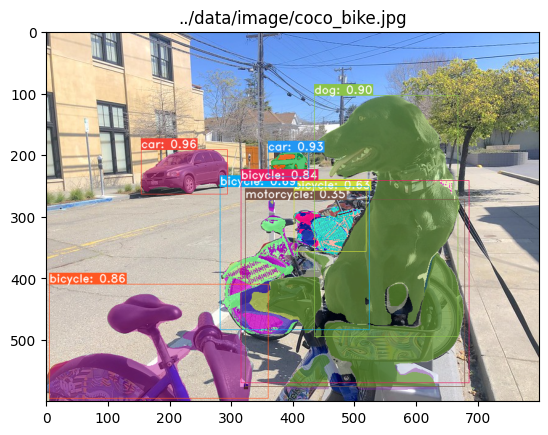

In [ ]:
image_inference(args.image)
